In [103]:
import pandas as pd
import numpy as np
import datetime
from collections import Counter

#api
import praw
import requests
from fake_useragent import UserAgent 


#pre-processing
import nltk 
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
# from nltk.tree import Tree
from nltk.stem.porter import *
# from nltk.tokenize import MWETokenizer 
from nltk import word_tokenize, pos_tag, ne_chunk
# import spacy
# from spacy import displacy
import en_core_web_sm
import re

#topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# import genism
from gensim.models import Word2Vec, KeyedVectors, LdaMulticore
from gensim import corpora, models, similarities, matutils

from NLP_functions import display_topics, prob_df, topic_matrix

#analysis
from sklearn.decomposition import TruncatedSVD, NMF

#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reddit = praw.Reddit(client_id='oCxykEUclueAuA', client_secret='M8wVQw3nFxMsXHLGxurnTtkN-Mdvtg', user_agent='Crypto')

Version 7.0.0 of praw is outdated. Version 7.2.0 was released 21 hours ago.


#### Get top posts of all time

In [3]:
posts = []
ml_subreddit = reddit.subreddit('Cryptocurrency')

for post in list(ml_subreddit.top('all', limit=1000)):
    date = datetime.datetime.utcfromtimestamp(post.created_utc)
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, date])
    
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'date'])
print(posts)

                                                 title  score      id  \
0    Elon Musk reminds me of a rich billionaire who...  39520  lce6zm   
1    CryptoNick is deleting all of his BitConnect v...  26496  7r0ftz   
2    Reminder: Robinhood blocked several stocks fro...  26360  lfrslo   
3    I will tell you exactly what is going on here,...  20140  7vga1y   
4    Robinhood is launching a Crypto Trading app to...  19965  7sx5ze   
..                                                 ...    ...     ...   
926                                        Every time.   1503  ldv9ea   
927         I'm something of a serious investor myself   1489  lo7joj   
928                    Are we moving too fast or what?   1477  lo2pa8   
929                               We're going camping!   1475  lnwpd3   
930  Not another fairy-tale ending - a word of warn...   1428  lfed9k   

          subreddit                                                url  \
0    CryptoCurrency  https://www.reddit.com/r/Cry

#### Get open day prices for BTC, ETH, DOGE, NANO, and XRB based on date of post

In [112]:
ua = UserAgent()
headers = {'user-agent': ua.random}

key = cryptocompare.cryptocompare._set_api_key_parameter('893488b8793438da44ad6d1e1093de1659841ad589583cf3f376dc468ffce72c')

In [114]:

cryptos = ['BTC', 'ETH', 'XRP','NANO', 'DOGE']

for c in cryptos:
    l = []
    
    for index, row in posts.iterrows():
        timestamp = (posts.loc[index,'date']).timestamp()
        url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={c}&tsym=USD&limit=1&toTs={timestamp}'
        url += key
        
        response = requests.get(url, headers=headers)  
        data = response.json()['Data']['Data']
        
        l.append(data[1]['open'])
        
        #change user agent, chosen randomly every 100 loops
        if index%50 == 0:
            headers = {'user-agent': ua.random}
        
    posts[c] = l
    print(posts)


                                                 title  score      id  \
0    Elon Musk reminds me of a rich billionaire who...  39520  lce6zm   
1    CryptoNick is deleting all of his BitConnect v...  26496  7r0ftz   
2    Reminder: Robinhood blocked several stocks fro...  26360  lfrslo   
3    I will tell you exactly what is going on here,...  20140  7vga1y   
4    Robinhood is launching a Crypto Trading app to...  19965  7sx5ze   
..                                                 ...    ...     ...   
926                                        Every time.   1503  ldv9ea   
927         I'm something of a serious investor myself   1489  lo7joj   
928                    Are we moving too fast or what?   1477  lo2pa8   
929                               We're going camping!   1475  lnwpd3   
930  Not another fairy-tale ending - a word of warn...   1428  lfed9k   

          subreddit                                                url  \
0    CryptoCurrency  https://www.reddit.com/r/Cry

In [116]:
posts.info()
posts.to_pickle('../Data/posts_price_df.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         931 non-null    object        
 1   score         931 non-null    int64         
 2   id            931 non-null    object        
 3   subreddit     931 non-null    object        
 4   url           931 non-null    object        
 5   num_comments  931 non-null    int64         
 6   body          931 non-null    object        
 7   date          931 non-null    datetime64[ns]
 8   BTC           931 non-null    float64       
 9   ETH           931 non-null    float64       
 10  XRP           931 non-null    float64       
 11  NANO          931 non-null    float64       
 12  DOGE          931 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 94.7+ KB


#### Get top coments from each top post

In [5]:
all_top_comments = []
for index, row in posts.iterrows():

    try:
        submission = reddit.submission(id=row['id'])
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments.list()])
        for x in comments[:20]:
            if x != '[deleted]' and 'Some Important Reminders' not in x and 'moderator' not in x:
                all_top_comments.append([x,row[7], row[8], row[9], row[10], row[11], row[12]])
#             print(all_top_comments)
    except:
        comments=None
all_top_comments = pd.DataFrame(all_top_comments,columns=['comment', 'date', 'BTC', 'ETH', 'XRP', 'NANO', 'DOGE'])
print(all_top_comments)

                                                 comment                date
0      If your life savings hinges on a Tweet from a ... 2021-02-04 12:02:16
1      I seriously don’t understand the obsession wit... 2021-02-04 12:02:16
2      Tbh u can't place all the blame on Elon tho, t... 2021-02-04 12:02:16
3      seriously, there's so much more relevant peopl... 2021-02-04 12:02:16
4      If I'm Elon, I put hundreds of millions into D... 2021-02-04 12:02:16
...                                                  ...                 ...
17776  You have a gambling addiction. Some people are... 2021-02-08 15:38:18
17777  Thanks for your cautionary tale, it's good at ... 2021-02-08 15:38:18
17778  Sorry to hear and a good lesson for everyone.\... 2021-02-08 15:38:18
17779  good lessons, thank you for sharing\n\ndont ch... 2021-02-08 15:38:18
17780  Man sending you a hug. so many of us were brou... 2021-02-08 15:38:18

[17781 rows x 2 columns]


## Cleaning

In [6]:
all_top_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17781 entries, 0 to 17780
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   comment  17781 non-null  object        
 1   date     17781 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 278.0+ KB


Add stop words and manual tokenizers

In [9]:
stop = stopwords.words('english')
stop = [w.replace("'", "") for w in stop] #remove apostrophes in stop words

stop = stop + ['moderator', 'subreddit', 'reddit' , 'question', 'concern', 'please', 'contact', 'im', 
        'people', 'gon', 'seems', 'something', 'year', 'like', 'mod', 'wa', 'thread', 'crypto', 'get',
        'see', 'deleted', 'ha', 'use', 'think', 'cryptocurrency', 'thing', 'one', 'even', 'want', 'need',
        'time', 'also', 'got', 'post', 'thats', 'probably', 'u', 'every', 'next', 'reason', 'na', 'give', 'lol',
        'everything', 'know', 'community', 'today', 'come', 'anyone', 'actually', 'removed', 'wtf', 'immage',
        'really', 'nice', 'man', 'work', 'day', 'way', 'would', 'could', 'said', 'submission', 'news', 'nice',
        'enjoy', 'find', 'work', 'job', 'flaired', 'inaccurately', 'click', 'action', 'performed', 'automatically',
        'ive', 'seen', 'sense', 'month', 'pretty', 'much', 'week', 'money', 'coin', 'market', 'right', 'let',
         'someone', 'guy', 'price', 'lot', 'transaction', 'feel', 'list', 'wow', 'well', 'go', 'take', 'thank',
        'something', 'shit', 'fuck', 'look', 'still', 'value', 'back', 'make', 'say', 'sure', 'new', 'happen',
        'buy', 'sell', 'word', 'start', 'trade', 'made', 'implement', 'gif', 'watch', 'worth', 'bought', 'sold',
        'total', 'idea', 'good', 'upvote', 'cant', 'never', 'love', 'oh', 'sub', 'repost', 'great', 'awesome',
        'best', 'quality', 'hope', 'big', 'discuss', 'project', 'believe', 'mean', 'virtual', 'trader',
        'user', 'payment', 'pay', 'try', 'many', 'bad', 'company', 'world', 'invest', 'stock', 'may', 'put',
        'first',  'point', 'already', 'everyon',  'ask',  'around', 'anoth', 'run', 'person'

            'keep', 'end', 'read', 'lose', 'gain', 'alway', 'understand', 'interest',  'last',
          'profit', 'life', 'edit', 'better', 'research', 'dollar', 'adopt',  'without',
         'amount', 'id', 'site',  'million',  'differ', 'help', 'tell', 'investor', 'sinc', 'went', 
         'decid',  'littl',  'inform', 'real', 'talk', 'noth', 'move', 'learn', 'small', 'chang', 
         'stop', 'compani', 'current', 'two', 'free', 'live', 'case',  'term', 
         'ga', 'send', 'card',  'check', 'game',  'full', 'cost',  'problem', 'transfer', 
         'top',  'platform', 'program', 'app', 'process', 'chain', 'issu', 
         'distribut', 'far', 'smart',  'gener', 'anyth', 'correct', 'system', 'huge', 'exist', 'ever', 
         'instead', 'advantag', 'easi',  'els', 'exampl', 'larg', 'creat', 'though', 'format', 
         'vote', 'either',   'support', 'tax', 'entir', 'cryptocurr', 'enough', 'might',
         'theyr', 'care', 'link',  'product', 'mayb', 'video', 'le', 'almost', 'posit', 
         'simpli', 'state', 'done', 'hard',  'internet', 'allow',  'complet', 'least', 'ill', 'fact', 
         'thought', 'stake', 'team', 'design', 'provid', 'stori', 'part', 'show', 'place', 'becom', 'data',
         'busi', 'articl', 'set', 'stuff',  'turn', 'howev', 'follow',  'call', 'possibl',
          'transact', 'order', 'block', 'agre', 'tech', 'ago', 'medium', 
          'respons',  'lost', 'low', 'option',  'past', 'yet',  'wrong', 'true',  
         'averag', 'must', 'number', 'rule', 'ye', 'hey', 'account', 'play', 'comment', 'major', 
         'away', 'hype', 'hous', 'save', 'activ', 'portfolio', 'rich', 'final', 'share', 'ignor', 'cours', 'name', 
         'expect', 'friend', 'economi', 'hand', 'extrem', 'mind', 'eventu', 'saw', 'side', 'claim', 'rather',
         'higher', 'liter', 'liquid', 'base', 'group', 'hear', 'control',  'push', 'due', 
         'kind',  'critic', 'whole', 'public',   'build', 'concept', 'specif',  'left', 
                
         'basic', 'releas',  'plan', 'abil', 'absolut',  'hour',  'add',  
         'loss', 'miss', 'easili', 'manag', 'potenti',  'guess',  'spend', 
         'whatev',  'sort',  'requir', 'standard', 'includ',  
         'rememb', 'bring', 'book', 'nobodi', 'longer', 'statement', 'act', 
         'opinion', 'belief', 'listen', 'rais', 'offer', 'solut', 'perspect', 
         'form', 'speak', 'wealth', 'found', 'strongli', 'heard', 'figur',  'answer', 
         'spent', 'accept', 'compar', 'reach',  'electr', 'miner',  'hit',  'replac',
         'stay', 'purchas',   'consid', 'reach',  'soon', 
         'imagin', 'per', 'renew',  'defy', 'built', 'attempt', 'earn', 'withdraw', 'effect', 'step', 
          'store', 'open', 'ad',  'singl', 'scale', 'zero', 'calcul', 
         'stabl',  'holder', 'fast', 'hit', 'plu', 'realiz', 'took',  'minut',  
          'return', 'chanc',  'digit', 'actual',  'billion', 
          'limit',  'old', 'seem', 'late', 'massiv', 'drive', 'wouldv',
               
         'coupl', 'strategi', 'earli', 'experi',  'happi', 'half',   'suppli', 'bigger', 
         'sustain',  'later', 'break', 'key', 'amaz',  'rel',  
         'comparison', 'meant', 'ride', 'caus', 'leav', 'told', 'note', 'decemb', 'crazi', 'exactli', 'consum', 
         'deal', 'sound', 'produc', 'serious', 'anyway', 'season',  'matter', 'becam',  
         'sever', 'recov', 'obvious', 'chart', 'sit', 'assum', 'win', 'lower', 'came',  
         'updat', 'websit', 'stupid',  'cool',  'access', 'moment', 'summari', 'fun', 
          'institut', 'forget', 'largest',  'estim', 'continu', 'biggest', 'lend', 
         'convert', 'multipl',  'settlement', 'simpl',  'tradit', 
         'report', 'proof', 'carri', 'similar', 'th', 'buck',  'begin', 'natur', 'wish', 'alon',  'sleep',
         'tangibl', 'perform', 'fail', 'popular', 'bot',
        'futur', 'high', 'rise', 'wait', 'beyond', 'financi', 'record', 'develop', 'effort', 'deposit', 'autom', 
        'monetari', 'force', 'impact','person', 'technic', 'contract', 'sourc', 'fair', 'subscrib','polit', 'softwar',
        'relat', 'captur', 'histori', 'practic', 'page','august', 'benefit', 'perhap', 'fan', 'neither', 'hater', 
        'hate', 'bullshit', 'clearli', 'straw', 'instant', 'custom', 'paid','volum', 'merchant', 'connect', 
               'network', 'valid', 'offic', 'resourc', 'announc', 'level', 'progress', 'plenti', 'ahead', 'success',
        'chief', 'address', 'industri', 'accus', 'necessarili', 'competitor', 'whose', 'determin', 'blockchain',
               'keep', 'funny', 'congratul', 'advic', 'weekend', 'reduc', 'verifi', 'wallet', 'toxic', 'emotion',
              'emote', 'remote']
#               'currenc', 'exchang', 'ico', 'token', 'wonder', 'ledger', 'hold', 'long', 'wallet', 'fund',
#               'moon', 'meme', 'dream', 'joke', ]

            
stop = set(stop)

# mwe_tokenizer = MWETokenizer([ ('bull','run'), ('market','cap'), ('pump','dump'), ('bitcoin','cash'),
#                              ('stock','market'), ('flaired', 'inaccurately'), ('make','money'), ('going','up'),
#                              ('going', 'down'), ('make','money'), ('go','up'), ('go', 'down'), ('dont', 'know')])
# mwe_tokenizer = MWETokenizer(('bitcoin','cash'))

# Init Lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = PorterStemmer()

In [10]:
def clean_str(row):
    '''
    clean comment string, removing numbers, punctuation, stop words, and changing to lowercase, 
    lemmatizing and stemming
    
    input: row of df
    
    output: cleaned string
    '''

    s = str(row[0]).lower() #lowercase
        
    s = re.sub(r'\([^)]*\)', '', s) #remove links
        
    #only alphabetical letters
    NON_ASCII = re.compile(r'[^a-z0-1\s]')
    s = NON_ASCII.sub(r'', s)
    
    s = re.sub(r'[0-9]+', '', s) #remove numbers
        
    #replace acronyms 
    s = s.replace('btc', 'bitcoin') 
    s = s.replace('dogecoin', 'doge') 
    s = s.replace('bitcoin cash', 'bch')
#     s = s.replace('bitcoin gold', 'bitcoin_gold')
#     s = s.replace('bitcoin sv', 'bitcoin_sv')
#     s = s.replace('bitcoin cash', 'bitcoin_cash')
    s = s.replace('ethereum', 'eth')
    s = s.replace('ripple', 'xrp')
#     s = s.replace(' alt ', ' altcoins ')
#     s = s.replace(' tri ', ' triangle ')
  
#     s_token = mwe_tokenizer.tokenize(word_tokenize(s))  # tokenize words
    s_token = word_tokenize(s)
    
    s_token = [w.strip() for w in s_token] #remove spaces
    
    s_token = [w for w in s_token if w not in stop] #remove stop words
        
    # Lemmatize and stem Single Word with the appropriate POS tag
#     s_token_lemm = [stemmer.stem(lemmatizer.lemmatize(w, get_wordnet_pos(w))) for w in s_token]

    s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token] #Lemmatize
    
    s_token_lemm_stem = [stemmer.stem(w) for w in s_token_lemm] #stem
        
    s_token_lemm_stem = [w for w in s_token_lemm_stem if w not in stop] #remove stop words
    
    s_lemm_stem = " ".join(s_token_lemm_stem) #join back into one string
    
#     s_lemm_stem = s_lemm_stem.replace('bitcoin bitcoin', 'bitcoin') #remove duplicated bitcoin occurences
#     s_lemm_stem = s_lemm_stem.replace('bitcoin ethereum', '')
#     s_lemm_stem = s_lemm_stem.replace('ethereum bitcoin', '')
#     s_lemm_stem = s_lemm_stem.replace('doge doge doge', 'doge')
#     s_lemm_stem = s_lemm_stem.replace('doge doge', 'doge')
#     s_lemm_stem = s_lemm_stem.replace('doge pump', 'pump')
#     s_lemm_stem = s_lemm_stem.replace('bitcoin eth', '')
#     s_lemm_stem = s_lemm_stem.replace('bitcoin doge', '')
#     s_lemm_stem = s_lemm_stem.replace('eth bitcoin', '')
#     s_lemm_stem = s_lemm_stem.replace('moon moon', 'moon')
#     s_lemm_stem = s_lemm_stem.replace('nano nano', 'nano')
#     s_lemm_stem = s_lemm_stem.replace('eth eth', 'eth')
#     s_lemm_stem = s_lemm_stem.replace('meme meme', 'meme')
#     s_lemm_stem = s_lemm_stem.replace('doge bitcoin', '')
#     s_lemm_stem = s_lemm_stem.replace('fee fee', 'fee')
#     s_lemm_stem = s_lemm_stem.replace('hold', 'hodl')
    
    return s_lemm_stem

In [11]:
top_comments = all_top_comments.copy()
top_comments['cleaned_comments'] = top_comments.apply (lambda row: clean_str(row), axis=1)
# top_comments['cleaned_comments'] = top_comments.apply(clean_str_list) 

Named Entitiy Recognition

In [12]:
def pos_only(row):
    s = row[2]
    
    s_token = word_tokenize(s)  # tokenize words
    
    s_pos = nltk.pos_tag(s_token)
    
    pos = []
    for x in s_pos:
        if x[1] == 'NN' or x[1] == 'VB' or x[1] == 'JJ':
            pos.append(x[0])
    
    return ' '.join([word for word in pos])

In [13]:
top_comments['nouns_verbs_adj'] = top_comments.apply (lambda row: pos_only(row), axis=1)

In [14]:
top_comments

,comment,date,cleaned_comments,nouns_verbs_adj
0,If your life savings hinges on a Tweet from a ...,2021-02-04 12:02:16,hing tweet billionair,tweet billionair
1,I seriously don’t understand the obsession wit...,2021-02-04 12:02:16,obsess elon musk space signific tweet rekt bor...,obsess elon musk space signific tweet rekt bor...
2,"Tbh u can't place all the blame on Elon tho, t...",2021-02-04 12:02:16,tbh blame elon tho yolo doge dumb af yolo twee...,tbh blame elon tho yolo doge dumb af yolo twee...
3,"seriously, there's so much more relevant peopl...",2021-02-04 12:02:16,relev cryptodltfintech obsess fascin idol norm...,relev cryptodltfintech obsess fascin idol norm...
4,"If I'm Elon, I put hundreds of millions into D...",2021-02-04 12:02:16,elon hundr doge dip tweet doge pull shock,elon hundr doge dip tweet doge pull shock
...,...,...,...,...
17776,You have a gambling addiction. Some people are...,2021-02-08 15:38:18,gambl addict hardwir,gambl addict hardwir
17777,"Thanks for your cautionary tale, it's good at ...",2021-02-08 15:38:18,cautionari tale recogn mistak head debt stabil...,cautionari tale recogn mistak debt stabil cheer
17778,Sorry to hear and a good lesson for everyone.\...,2021-02-08 15:38:18,sorri lesson dca afford loos bank,sorri lesson dca afford bank
17779,"good lessons, thank you for sharing\n\ndont ch...",2021-02-08 15:38:18,lesson chase,lesson chase


### EDA of all Comments to get stop words

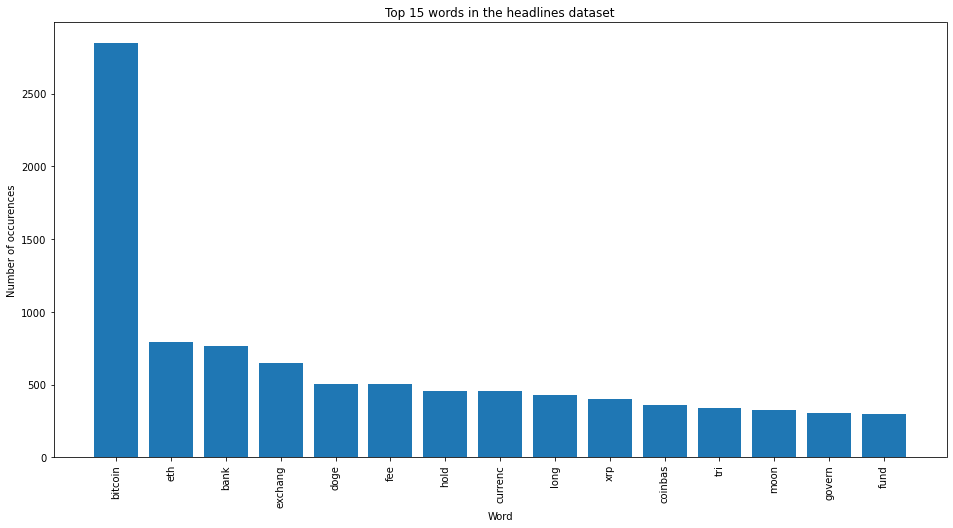

In [15]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(top_comments['cleaned_comments'],15):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in the headlines dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

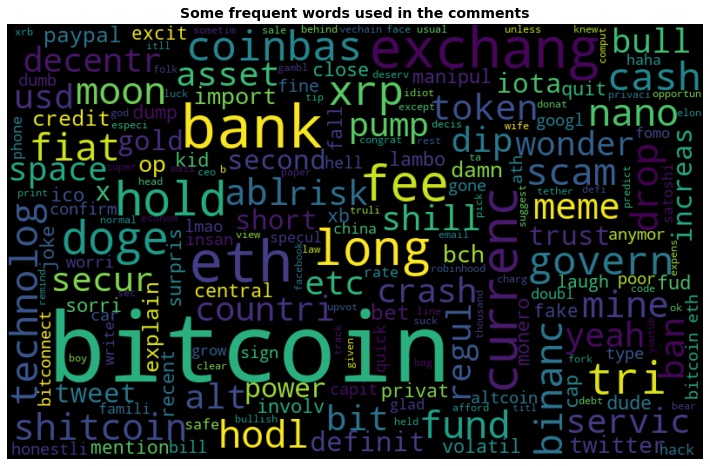

In [16]:
all_words = ' '.join([word for word in top_comments['cleaned_comments']])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', 
#                       colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

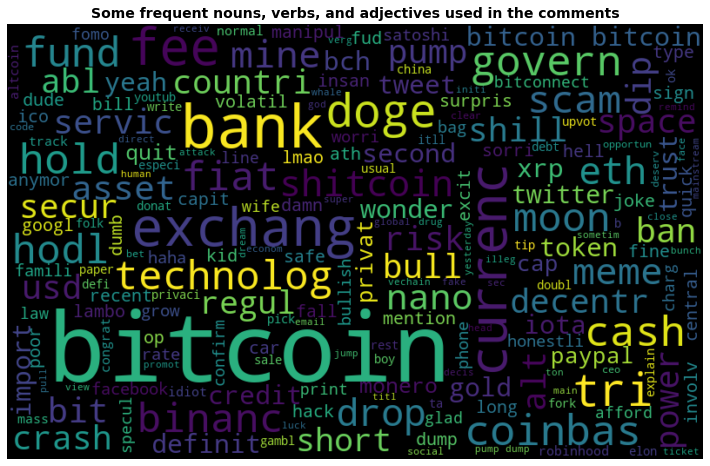

In [17]:
all_nouns = ' '.join([word for word in top_comments['nouns_verbs_adj']])
all_nouns
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', 
#                       colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns, verbs, and adjectives used in the comments", weight='bold', fontsize=14)
plt.show()

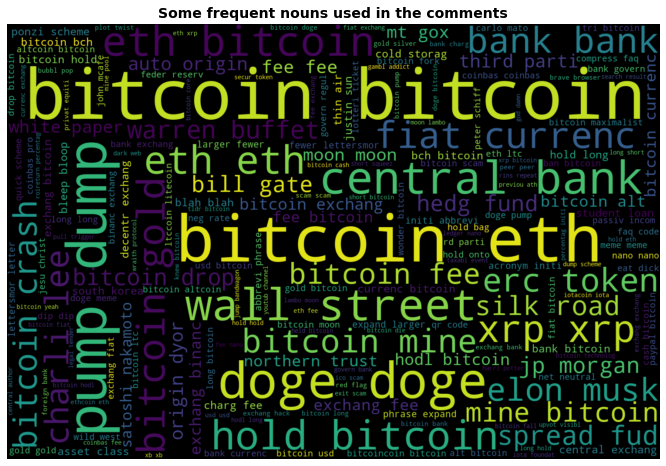

In [18]:
nltk_tokens = nltk.word_tokenize(all_words)  
bigrams_list = list(nltk.bigrams(top_comments['cleaned_comments']))

dictionary2 = [' '.join(tup) for tup in bigrams_list]


#Using count vectoriser to view the frequency of bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(dictionary2)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()

# Topic Modeling

In [19]:
comments = list(top_comments['cleaned_comments'])

topics = 3
topic_words = 6
topic_names = None
maxdf = None
mindf = 20

### Count Vectorization

In [20]:
cv = CountVectorizer(stop_words=stop) #min_df = 20)
X_cv = cv.fit_transform(comments)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Latent Semantic Analysis (LSA) with Count Vectorization

In [21]:
lsa_cv = TruncatedSVD(6)
X_lsa_cv = lsa_cv.fit_transform(X_cv)
lsa_cv.explained_variance_ratio_

array([0.04157608, 0.0216791 , 0.01365223, 0.01124772, 0.00914554,
       0.00821511])

In [22]:
display_topics(lsa_cv, cv.get_feature_names(), topic_words, topic_names)


Topic  0
bitcoin, bank, eth, exchang, bch, hold

Topic  1
bank, exchang, currenc, central, servic, govern

Topic  2
eth, trust, fund, token, northern, servic

Topic  3
trust, northern, servic, fund, privat, equiti

Topic  4
eth, bank, central, rate, trust, northern

Topic  5
xrp, iota, doge, nano, fud, govern


#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [23]:
nmf_cv = NMF(9)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
# nmf_cv.explained_variance_ratio_

In [24]:
display_topics(nmf_cv, cv.get_feature_names(), 10, topic_names)


Topic  0
bitcoin, bch, gold, energi, mine, hold, fork, long, origin, alt

Topic  1
bank, currenc, central, rate, neg, govern, morgan, crisi, exchang, servic

Topic  2
eth, decentr, token, long, hold, coinbas, eo, ico, short, node

Topic  3
trust, servic, fund, northern, privat, asset, equiti, cherecwich, token, hedg

Topic  4
exchang, fee, coinbas, binanc, fiat, fund, charg, lightn, paypal, shitcoin

Topic  5
iota, govern, mail, cryptographi, cypherpunk, node, technolog, privaci, secur, origin

Topic  6
xrp, secur, pump, sec, fud, hold, lawsuit, fund, coinbas, dump

Topic  7
doge, meme, pump, moon, hold, currenc, dump, robinhood, solv, dash

Topic  8
nano, shill, fud, spread, brigad, neg, troll, emot, ration, currenc


#### LDA with Count Vectorization 

In [25]:
X_cv = X_cv.transpose()

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(X_cv)

# save a mapping (dict) of row id to word (token) for later use by gensim
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda_cv = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=5)

# pd.DataFrame(X_cv.toarray(), cv.get_feature_names()).head()
lda_cv.print_topics()

[(0,
  '0.018*"nano" + 0.015*"moon" + 0.014*"scam" + 0.014*"bitcoin" + 0.009*"mine" + 0.007*"fall" + 0.007*"token" + 0.006*"ico" + 0.005*"ban" + 0.005*"dumb"'),
 (1,
  '0.029*"bitcoin" + 0.026*"eth" + 0.021*"xrp" + 0.013*"currenc" + 0.011*"coinbas" + 0.009*"fiat" + 0.008*"decentr" + 0.008*"paypal" + 0.007*"monero" + 0.006*"central"'),
 (2,
  '0.020*"doge" + 0.010*"meme" + 0.007*"govern" + 0.006*"googl" + 0.006*"technolog" + 0.006*"trust" + 0.005*"tri" + 0.005*"alt" + 0.005*"token" + 0.004*"tether"'),
 (3,
  '0.083*"bitcoin" + 0.028*"bank" + 0.010*"shitcoin" + 0.007*"dip" + 0.007*"long" + 0.006*"crash" + 0.006*"cap" + 0.005*"cash" + 0.005*"regul" + 0.005*"govern"'),
 (4,
  '0.023*"fee" + 0.014*"exchang" + 0.013*"hodl" + 0.013*"hold" + 0.013*"pump" + 0.011*"eth" + 0.011*"gold" + 0.011*"binanc" + 0.009*"dump" + 0.008*"fund"'),
 (5,
  '0.014*"shill" + 0.013*"iota" + 0.009*"bull" + 0.009*"lambo" + 0.008*"drop" + 0.008*"verg" + 0.008*"bch" + 0.008*"dude" + 0.008*"haha" + 0.007*"sorri"')]

In [26]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda_cv[corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

# lda_docs

## TF-IDF Vectorizer

In [27]:
# tfid = TfidfVectorizer(stop_words= stop, ngram_range=(1, 3), min_df=5)
tfid = TfidfVectorizer(stop_words= stop, min_df=5)
X_tfid = tfid.fit_transform(comments)
# pd.DataFrame(X_tfid.toarray(), columns=tfid.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization 

In [28]:

nmf_tfid = NMF(6)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)

In [29]:
display_topics(nmf_tfid, tfid.get_feature_names(), 8, topic_names)


Topic  0
bitcoin, gold, alt, mine, currenc, hodl, bch, drop

Topic  1
doge, pump, meme, joke, mine, elon, dump, wonder

Topic  2
eth, alt, hold, token, ath, ltc, long, short

Topic  3
moon, meme, lambo, alt, farm, upvot, shitcoin, congrat

Topic  4
bank, fee, exchang, coinbas, nano, binanc, currenc, fiat

Topic  5
xrp, hold, dump, pump, long, hodl, scam, glad


## Word2Vec

In [30]:
# texts = [[word for word in document.lower().split()]
#          for document in comments]

# w2v = Word2Vec(texts, sg=1,workers=4,size=500, min_count=1, window=10 ) #using skip-gram

In [31]:
# w2v.most_similar('privaci', topn=5)

## Final topic model 

In [32]:
def topic_matrix(model, feature_names, topics):
    idx = topics

    topic_word = pd.DataFrame(model.components_.round(3),
             index = idx,
             columns = feature_names)
    
    topic_word = topic_word.T
    topic_word['topic_choice'] = topic_word.idxmax(axis=1)
    topic_word['max_value'] = topic_word.max(axis=1)
    
    return topic_word

word_df = topic_matrix(nmf_cv, cv.get_feature_names(), ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#svae as csv on data folder
word_df.to_csv('../Data/word_topic_analysis.csv')

In [33]:
def prob_df(X, topics):
    cols = topics

    df = pd.DataFrame(X.round(5), columns = cols)
    df['topic_choice'] = df.idxmax(axis=1)
    df['topic_value'] = df.max(axis=1)
   
    return df
nmf_tfid_probs = prob_df(X_nmf_cv, ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

nmf_tfid_probs['date'] = top_comments['date']
nmf_tfid_probs['comment'] = top_comments['comment']

nmf_tfid_probs

,Bitcoin,CBDC,Ethereum,Trusts,Exchanges,Privacy,Ripple,Doge,Nano,topic_choice,topic_value,date,comment
0,0.00133,0.00000,0.00011,0.00000,0.00000,0.00230,0.00284,0.00344,0.00000,Doge,0.00344,2021-02-04 12:02:16,If your life savings hinges on a Tweet from a ...
1,0.10794,0.00000,0.00834,0.00775,0.00000,0.00503,0.00546,0.01161,0.00000,Bitcoin,0.10794,2021-02-04 12:02:16,I seriously don’t understand the obsession wit...
2,0.00094,0.00000,0.00000,0.00000,0.00163,0.00000,0.00178,0.20678,0.00103,Doge,0.20678,2021-02-04 12:02:16,"Tbh u can't place all the blame on Elon tho, t..."
3,0.00410,0.00000,0.00982,0.00000,0.00444,0.00970,0.00222,0.00312,0.00068,Ethereum,0.00982,2021-02-04 12:02:16,"seriously, there's so much more relevant peopl..."
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.37817,0.00000,Doge,0.37817,2021-02-04 12:02:16,"If I'm Elon, I put hundreds of millions into D..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17776,0.00103,0.00136,0.00000,0.00000,0.00123,0.00144,0.00000,0.00011,0.00000,Privacy,0.00144,2021-02-08 15:38:18,You have a gambling addiction. Some people are...
17777,0.00119,0.00249,0.00151,0.00021,0.00461,0.00495,0.00000,0.00097,0.00032,Privacy,0.00495,2021-02-08 15:38:18,"Thanks for your cautionary tale, it's good at ..."
17778,0.00000,0.11008,0.00052,0.00000,0.00000,0.00000,0.00243,0.00000,0.00000,CBDC,0.11008,2021-02-08 15:38:18,Sorry to hear and a good lesson for everyone.\...
17779,0.00016,0.00000,0.00112,0.00000,0.00388,0.00006,0.00013,0.00059,0.00006,Exchanges,0.00388,2021-02-08 15:38:18,"good lessons, thank you for sharing\n\ndont ch..."


In [34]:
nmf_tfid_probs['topic_choice'].value_counts(normalize=True)

Bitcoin      0.219167
Privacy      0.178111
Exchanges    0.146955
Doge         0.110849
Trusts       0.079242
Nano         0.076317
Ethereum     0.071031
Ripple       0.063607
CBDC         0.054721
Name: topic_choice, dtype: float64

## Sentiment Analysis

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiments(df):
    
    df['compound'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['compound'])
    df['positive'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['pos'])
    df['neutral'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['neu'])
    df['negative'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['neg'])
    df['sentiment'] = df['compound'].apply(lambda c: 'posititve' if c >=0 else 'negative')
#     df['sentiment'] = df[['positive', 'neutral', 'negative']].idxmax(axis=1)
#     df['sentiment_value'] = df[['positive', 'neutral', 'negative']].max(axis=1)

    return df

comment_topic_sentiment_df = get_sentiments(nmf_tfid_probs)



In [36]:
comment_topic_sentiment_df

,Bitcoin,CBDC,Ethereum,Trusts,Exchanges,Privacy,Ripple,Doge,Nano,topic_choice,topic_value,date,comment,compound,positive,neutral,negative,sentiment
0,0.00133,0.00000,0.00011,0.00000,0.00000,0.00230,0.00284,0.00344,0.00000,Doge,0.00344,2021-02-04 12:02:16,If your life savings hinges on a Tweet from a ...,-0.3400,0.000,0.882,0.118,negative
1,0.10794,0.00000,0.00834,0.00775,0.00000,0.00503,0.00546,0.01161,0.00000,Bitcoin,0.10794,2021-02-04 12:02:16,I seriously don’t understand the obsession wit...,-0.7906,0.026,0.833,0.141,negative
2,0.00094,0.00000,0.00000,0.00000,0.00163,0.00000,0.00178,0.20678,0.00103,Doge,0.20678,2021-02-04 12:02:16,"Tbh u can't place all the blame on Elon tho, t...",0.2883,0.122,0.790,0.088,posititve
3,0.00410,0.00000,0.00982,0.00000,0.00444,0.00970,0.00222,0.00312,0.00068,Ethereum,0.00982,2021-02-04 12:02:16,"seriously, there's so much more relevant peopl...",0.1280,0.078,0.806,0.116,posititve
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.37817,0.00000,Doge,0.37817,2021-02-04 12:02:16,"If I'm Elon, I put hundreds of millions into D...",0.7321,0.174,0.826,0.000,posititve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17776,0.00103,0.00136,0.00000,0.00000,0.00123,0.00144,0.00000,0.00011,0.00000,Privacy,0.00144,2021-02-08 15:38:18,You have a gambling addiction. Some people are...,0.0000,0.000,1.000,0.000,posititve
17777,0.00119,0.00249,0.00151,0.00021,0.00461,0.00495,0.00000,0.00097,0.00032,Privacy,0.00495,2021-02-08 15:38:18,"Thanks for your cautionary tale, it's good at ...",0.8402,0.301,0.607,0.091,posititve
17778,0.00000,0.11008,0.00052,0.00000,0.00000,0.00000,0.00243,0.00000,0.00000,CBDC,0.11008,2021-02-08 15:38:18,Sorry to hear and a good lesson for everyone.\...,0.0772,0.077,0.827,0.096,posititve
17779,0.00016,0.00000,0.00112,0.00000,0.00388,0.00006,0.00013,0.00059,0.00006,Exchanges,0.00388,2021-02-08 15:38:18,"good lessons, thank you for sharing\n\ndont ch...",0.8576,0.599,0.401,0.000,posititve


## Get Cryptocurrency prices

In [ ]:
#svae as csv on data folder
comment_topic_sentiment_price_df.to_csv('../Data/topic_sentiment_analysis_comments.csv')

In [41]:
comment_topic_sentiment_price_df.head()

,Bitcoin,CBDC,Ethereum,Trusts,Exchanges,Privacy,Ripple,Doge,Nano,topic_choice,topic_value,date,comment,compound,positive,neutral,negative,sentiment
0,0.00133,0.0,0.00011,0.00000,0.00000,0.00230,0.00284,0.00344,0.00000,Doge,0.00344,2021-02-04 12:02:16,If your life savings hinges on a Tweet from a ...,-0.3400,0.000,0.882,0.118,negative
1,0.10794,0.0,0.00834,0.00775,0.00000,0.00503,0.00546,0.01161,0.00000,Bitcoin,0.10794,2021-02-04 12:02:16,I seriously don’t understand the obsession wit...,-0.7906,0.026,0.833,0.141,negative
2,0.00094,0.0,0.00000,0.00000,0.00163,0.00000,0.00178,0.20678,0.00103,Doge,0.20678,2021-02-04 12:02:16,"Tbh u can't place all the blame on Elon tho, t...",0.2883,0.122,0.790,0.088,posititve
3,0.00410,0.0,0.00982,0.00000,0.00444,0.00970,0.00222,0.00312,0.00068,Ethereum,0.00982,2021-02-04 12:02:16,"seriously, there's so much more relevant peopl...",0.1280,0.078,0.806,0.116,posititve
4,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.37817,0.00000,Doge,0.37817,2021-02-04 12:02:16,"If I'm Elon, I put hundreds of millions into D...",0.7321,0.174,0.826,0.000,posititve


In [ ]:
# from sklearn.cluster import KMeans
# km = KMeans(
#     n_clusters=2, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(X_wtv)
# df = pd.DataFrame({'year' :comments, 'topic_cluster' :y_km })
# df

In [ ]:
# from sklearn.manifold import TSNE
# model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
#                         n_iter=1000, verbose=1, random_state=0, angle=0.75)
# tsne_features = model.fit_transform(lda_matrix)
# df = pd.DataFrame(tsne_features)
# df['topic'] = lda_matrix.argmax(axis=1)
# df.columns = ['TSNE1', 'TSNE2', 'topic']
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# plt.title('T-SNE plot of different headlines ( headlines are clustered among their topics)')
# ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df, legend = 'full')
# plt.show()

In [ ]:
# def get_top_n_words(corpus, n=10):
#   vec = CountVectorizer(stop_words='english').fit(corpus)
#   bag_of_words = vec.transform(corpus)
#   sum_words = bag_of_words.sum(axis=0) 
#   words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
#   words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#   return words_freq[:n]
# words = []
# word_values = []
# for i,j in get_top_n_words(headlines['headline_text'],15):
#   words.append(i)
#   word_values.append(j)
# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(range(len(words)), word_values);
# ax.set_xticks(range(len(words)));
# ax.set_xticklabels(words, rotation='vertical');
# ax.set_title('Top 15 words in the headlines dataset');
# ax.set_xlabel('Word');
# ax.set_ylabel('Number of occurences');
# plt.show()
